In [12]:
# Standard imports
import os
import torch
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
from scipy.sparse import csr_matrix

# Imports for displaying vis in Colab / notebook

torch.set_grad_enabled(False)

# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


In [2]:
def find_json_file(n, directory='.'):
    best_file = None
    best_end = None

    # List all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            # Extract the range from the filename
            start, end = map(int, filename.rstrip('.json').split('-'))

            # Check if n is within the range
            if start <= n <= end:
                if best_file is None or end > best_end or (end == best_end and n == end):
                    best_file = filename
                    best_end = end

    return best_file, n-int(best_file.rstrip('.json').split('-')[0])

def load_json_from_file(filename):
    with open(filename, 'r') as file:
        return json.load(file)

def load_json_from_feature(feature, directory='.'):
    json_file, m = find_json_file(feature, directory)
    return load_json_from_file(os.path.join(directory, json_file))[m]


In [28]:
# load the feature matrix
with open('raw_neg_feature_mat.pkl', 'rb') as f:
    raw_neg_feature_mat_sparse = pickle.load(f)
    neg_feature_mat = raw_neg_feature_mat_sparse.to_dense()

with open('raw_pos_feature_mat.pkl', 'rb') as f:
    raw_pos_feature_mat_sparse = pickle.load(f)
    pos_feature_mat = raw_pos_feature_mat_sparse.to_dense()

/home/hasith/anaconda3/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [29]:
# Make a tensor of the same shape as the feature matrices, with elements that are the maxActApprox of the jth feature
# list of files in directory
total_features = 24576
directory = "./data/"
file_list = os.listdir(directory)
maxActApprox = torch.zeros((total_features,))
for f in tqdm(file_list):
    file = os.path.join(directory, f)
    start, end = map(int, f.rstrip('.json').split('-'))
    jsondata = load_json_from_file(file)
    for i in range(start, end):
        maxActApprox[i] = max(np.abs(jsondata[i-start]['maxActApprox']), float(torch.max(torch.abs(pos_feature_mat[:,i]))), float(torch.max(torch.abs(neg_feature_mat[:,i]))))

# maxActApprox = torch.tensor([load_json_from_feature(j, directory)['maxActApprox'] for j in tqdm(range(total_features))])
maxActApprox = maxActApprox.unsqueeze(0).repeat(total_features, 1)

100%|██████████| 192/192 [00:57<00:00,  3.32it/s]


In [30]:
# count number of zeroes in maxActApprox
max_zeroes_count = torch.sum(maxActApprox[0,:] == 0).item()
print(f"Number of zeroes in maxActApprox: {max_zeroes_count}")

# Drop the zero rows and columns from the matrices later on
nonzero_max_features = ~(maxActApprox[0,:] == 0)

# count number of columns in the matrices that are all zero
neg_num_zero_cols = torch.sum(torch.all(neg_feature_mat == 0, dim=0)).item()
pos_num_zero_cols = torch.sum(torch.all(pos_feature_mat == 0, dim=0)).item()
print(f"Number of zero columns in neg_feature_mat: {neg_num_zero_cols}")
print(f"Number of zero columns in pos_feature_mat: {pos_num_zero_cols}")

# Drop the zero columns from the matrices later on
nonzero_neg_res_features = ~(torch.all(neg_feature_mat == 0, dim=0)) 
nonzero_pos_res_features = ~(torch.all(pos_feature_mat == 0, dim=0))

# Keep only these features
# good_features = torch.logical_and(nonzero_act_features, nonzero_res_features)
good_pos = torch.logical_and(nonzero_max_features, nonzero_pos_res_features)
good_neg = torch.logical_and(nonzero_max_features, nonzero_neg_res_features)

Number of zeroes in maxActApprox: 5


Number of zero columns in neg_feature_mat: 24310
Number of zero columns in pos_feature_mat: 24310


/home/hasith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hasith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

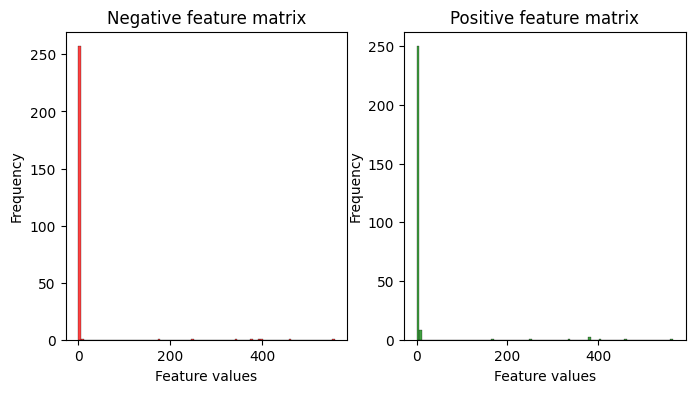

In [31]:
# plot histograms of the feature matrices
import matplotlib.pyplot as plt
import seaborn as sns

np_neg_feature_mat = neg_feature_mat.numpy()[good_neg,good_pos]
np_pos_feature_mat = pos_feature_mat.numpy()[good_pos,good_pos]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(np_neg_feature_mat, bins=100, color='red')
plt.title("Negative feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(np_pos_feature_mat, bins=100, color='green')
plt.title("Positive feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

In [32]:
# Element-wise division of the feature matrices by the maxActApprox tensor
normed_neg_feature_mat = neg_feature_mat / maxActApprox
normed_pos_feature_mat = pos_feature_mat / maxActApprox

/home/hasith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hasith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

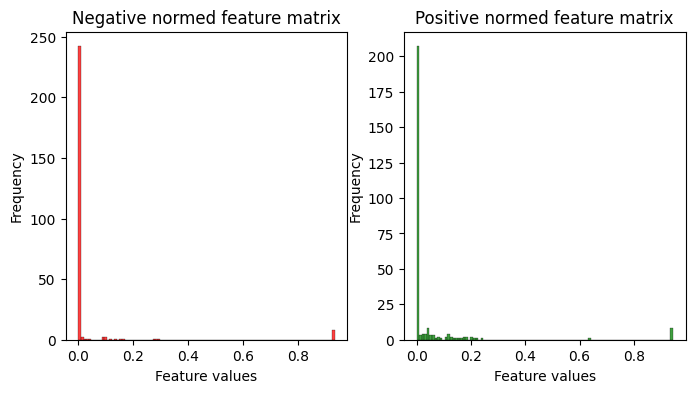

In [33]:
# plot histograms of the normed feature matrices
np_normed_neg_feature_mat = normed_neg_feature_mat.numpy()[good_neg,good_neg]
np_normed_pos_feature_mat = normed_pos_feature_mat.numpy()[good_pos,good_pos]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(np_normed_neg_feature_mat, bins=100, color='red')
plt.title("Negative normed feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(np_normed_pos_feature_mat, bins=100, color='green')
plt.title("Positive normed feature matrix")
plt.xlabel("Feature values")
plt.ylabel("Frequency")

In [47]:
normed_neg_feature_mat.numpy()[:,good_neg][good_neg,:].shape

(266, 266)

In [40]:
def matrix_to_dataframe(matrix, features):
    """
    Converts a square NumPy array into a Pandas DataFrame with columns "source", "target", and "weight".
    
    Parameters:
    matrix (np.array): The square matrix to convert.
    features (list): The list of feature names.
    
    Returns:
    pd.DataFrame: The resulting DataFrame.
    """
    # Ensure the matrix is square
    assert matrix.shape[0] == matrix.shape[1], "The matrix must be square."
    
    # Ensure the number of features matches the matrix dimensions
    assert len(features) == matrix.shape[0], "The length of features must match the matrix dimensions."
    
    # Create a DataFrame by iterating over the matrix
    data = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            data.append({
                "source": features[i],
                "target": features[j],
                "weight": matrix[i, j]
            })
    
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data) 
    
    return df

# Group the matrix
# group_size = 1000  # The size of each group
# pos_grouped_matrix, pos_grouped_ranges = group_sparse_matrix(torch.abs(normed_pos_feature_mat_sparse), group_size)
# neg_grouped_matrix, neg_grouped_ranges = group_sparse_matrix(torch.abs(normed_neg_feature_mat_sparse), group_size)

In [42]:
np_normed_neg_feature_mat.shape

(266,)

Text(627.9949494949494, 0.5, 'Feature index')

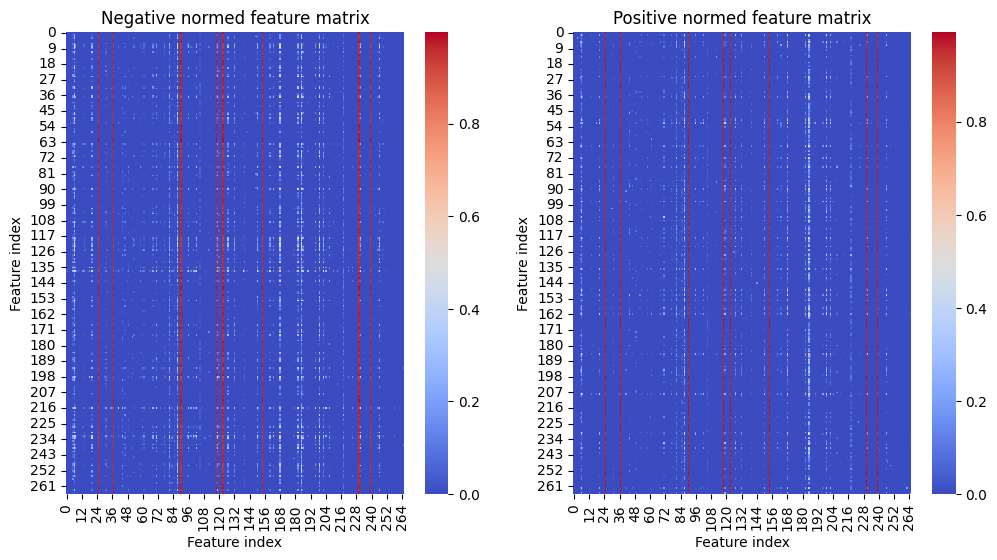

In [48]:
# Make a heatmap of the good features
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(normed_neg_feature_mat.numpy()[:,good_neg][good_neg,:], ax=ax[0], cmap='coolwarm')
ax[0].set_title("Negative normed feature matrix")
ax[0].set_xlabel("Feature index")
ax[0].set_ylabel("Feature index")

sns.heatmap(normed_pos_feature_mat.numpy()[:,good_neg][good_neg,:], cmap='coolwarm')
ax[1].set_title("Positive normed feature matrix")
ax[1].set_xlabel("Feature index")
ax[1].set_ylabel("Feature index")

In [80]:
def group_matrix(matrix, group_size, features):
    """
    Groups the matrix into blocks of size group_size x group_size and returns the grouped matrix and the ranges of the groups.
    
    Parameters:
    matrix (torch.Tensor): The matrix to group.
    group_size (int): The size of each group.
    features (list): The list of feature names.
    
    Returns:
    torch.Tensor: The grouped matrix.
    list: The ranges of the groups.
    """
    # Ensure the matrix is square
    assert matrix.shape[0] == matrix.shape[1], "The matrix must be square."
    
    # Ensure the number of features matches the matrix dimensions
    assert len(features) == matrix.shape[0], "The length of features must match the matrix dimensions."
    
    # Calculate the number of groups
    num_groups = (matrix.shape[0] + group_size - 1) // group_size
    
    # Group the matrix
    grouped_matrix = torch.zeros((num_groups, num_groups))
    for i in range(num_groups):
        for j in range(num_groups):
            if i == num_groups - 1:
                end_i = matrix.shape[0]
            else:
                end_i = (i+1)*group_size
            
            if j == num_groups - 1:
                end_j = matrix.shape[1]
            else:
                end_j = (j+1)*group_size

            grouped_matrix[i, j] = torch.mean(matrix[i*group_size:end_i, j*group_size:end_j])
    
    # Create the ranges
    ranges = []
    for i in range(num_groups):
        if i == num_groups - 1:
            ranges.append(str(features[i*group_size].item()) + "-" + str(features[-1].item()))
        else:
            ranges.append(str(features[i*group_size].item()) + "-" + str(features[(i+1)*group_size-1].item()))
    
    return grouped_matrix, ranges

In [81]:
good_neg_features = torch.arange(normed_neg_feature_mat.shape[0])[good_neg]
good_pos_features = torch.arange(normed_pos_feature_mat.shape[0])[good_pos]

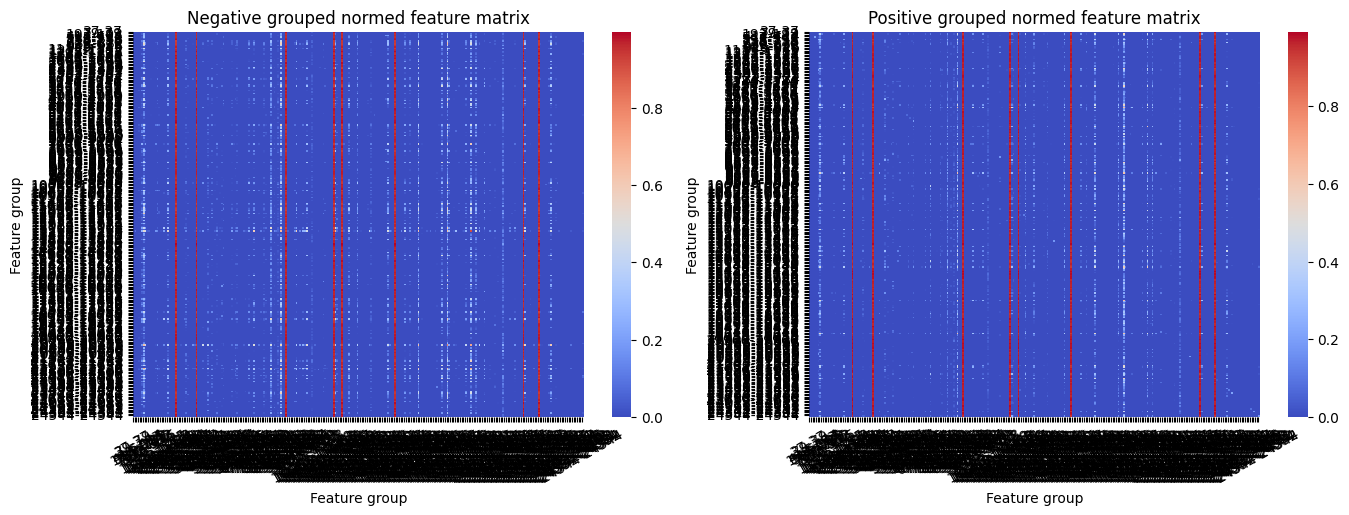

In [93]:
grouped_neg_feature_mat, neg_grouped_ranges = group_matrix(normed_neg_feature_mat[:,good_neg][good_neg,:], 1, good_neg_features)
grouped_pos_feature_mat, pos_grouped_ranges = group_matrix(normed_pos_feature_mat[:,good_neg][good_neg,:], 1, good_pos_features)

# Make a heatmap of the grouped matrices
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(grouped_neg_feature_mat, ax=ax[0], cmap='coolwarm')
ax[0].set_title("Negative grouped normed feature matrix")
ax[0].set_xlabel("Feature group")
ax[0].set_ylabel("Feature group")

sns.heatmap(grouped_pos_feature_mat, ax=ax[1], cmap='coolwarm')
ax[1].set_title("Positive grouped normed feature matrix")
ax[1].set_xlabel("Feature group")
ax[1].set_ylabel("Feature group")

# Set the ticks
ax[0].set_xticks(np.arange(grouped_neg_feature_mat.shape[0]))
ax[0].set_xticklabels(neg_grouped_ranges, rotation=30)
ax[0].set_yticks(np.arange(grouped_neg_feature_mat.shape[1]))
ax[0].set_yticklabels(neg_grouped_ranges, rotation=0)

ax[1].set_xticks(np.arange(grouped_pos_feature_mat.shape[0]))
ax[1].set_xticklabels(pos_grouped_ranges, rotation=30)
ax[1].set_yticks(np.arange(grouped_pos_feature_mat.shape[1]))
ax[1].set_yticklabels(pos_grouped_ranges, rotation=0);

In [94]:
# Display the feature matrix as a chord diagram
from d3blocks import D3Blocks

# Initialize
d3 = D3Blocks()

# Load example data
M_pos = grouped_pos_feature_mat.numpy() 
df_pos = matrix_to_dataframe(M_pos, pos_grouped_ranges)

M_neg = grouped_neg_feature_mat.numpy()
df_neg = matrix_to_dataframe(M_neg, neg_grouped_ranges)

# d3.chord(df)
d3.chord(df_pos, filepath="./pos_feature_matrix.html", ordering=pos_grouped_ranges)
d3.chord(df_neg, filepath="./neg_feature_matrix.html", ordering=neg_grouped_ranges)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/home/hasith/projects/sae_tut/ARENA_3.0/chapter1_transformer_interp/exercises/part4_superposition_and_saes/pos_feature_matrix.html]
[d3blocks] >INFO> Convert to DataFrame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/home/hasith/projects/sae_tut/ARENA_3.0/chapter1_transformer_interp/exercises/part4_superposition_and_saes/pos_feature_matrix.html]
[d3blocks] >INFO> Open browser: /home/hasith/projects/sae_tut/ARENA_3.0/chapter1_transformer_interp/exercises/part4_superposition_and_saes/pos_feature_matrix.html
[d3blocks] >INFO> Cleaning edge_p

Text(0, 0.5, 'Feature value')

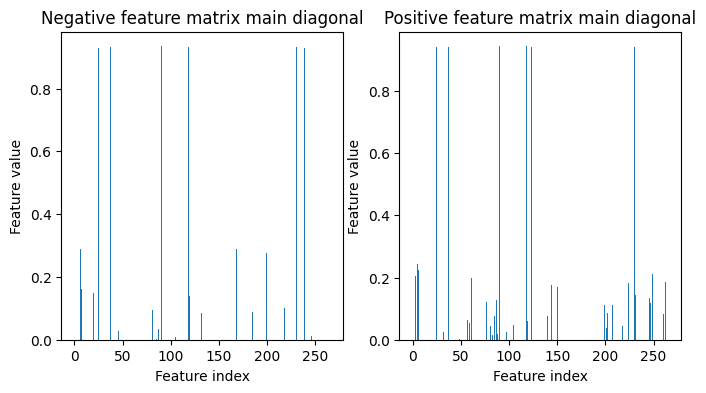

In [96]:
# Plot bar chart of the main diagonal of the feature matrices
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.bar(np.arange(grouped_neg_feature_mat.shape[0]), np.diag(grouped_neg_feature_mat))
plt.title("Negative feature matrix main diagonal")
plt.xlabel("Feature index")
plt.ylabel("Feature value")

plt.subplot(1, 2, 2)
plt.bar(np.arange(grouped_pos_feature_mat.shape[0]), np.diag(grouped_pos_feature_mat))
plt.title("Positive feature matrix main diagonal")
plt.xlabel("Feature index")
plt.ylabel("Feature value")

In [100]:
# find the indices of the top 5 features in the main diagonal of the positive feature matrix
top_pos_features = np.argsort(np.diag(grouped_pos_feature_mat))[-6:]

# find the corresponding feature names
top_pos_feature_names = [pos_grouped_ranges[i] for i in top_pos_features]
top_pos_feature_names

['21561-21561',
 '11904-11904',
 '3257-3257',
 '2186-2186',
 '11433-11433',
 '8598-8598']